<a href="https://colab.research.google.com/github/EsteTro/Machine-Learning-Projects/blob/main/Final_BTCUSD_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de predicción de RF para el par BTC/USD intervalo de 1d

# Importaciones

In [ ]:
#Installing Python modules
!pip install fastai==0.7.0
!pip install scikit-learn==0.21.3

#Data manipulation
import pandas as pd
import numpy as np
from time import time
import datetime

#Importing deep learning librery
from fastai.imports import *
from fastai.tabular import *

#Import packages
import math, re, IPython, graphviz

#Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from pprint import pprint

#Importing automatic learning packages
from sklearn import metrics , tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import train_test_split , RandomizedSearchCV

from IPython.display import Image , display

     |████████████████████████████████| 112 kB 5.2 MB/s 
     |████████████████████████████████| 128 kB 41.0 MB/s 
     |████████████████████████████████| 294 kB 49.0 MB/s 
ERROR: Could not find a version that satisfies the requirement torch<0.4 (from fastai) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0)
ERROR: No matching distribution found for torch<0.4
     |████████████████████████████████| 6.7 MB 4.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Captura de datos (Con CSV)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BTC_day.csv to BTC_day.csv
User uploaded file "BTC_day.csv" with length 117411 bytes


In [ ]:
df = pd.read_csv("BTC_day.csv")
df.index = df['timestamp']
df['y']=df['close']

In [ ]:
df.drop(df.head(0).index,inplace=True)

In [ ]:
print(df.info())
print('\n')
print("Número de muestras:", df.shape[0])
print("Número de variables:", df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Index: 1438 entries, 5/10/2016 to 4/16/2020
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1438 non-null   object 
 1   open       1438 non-null   float64
 2   high       1438 non-null   float64
 3   low        1438 non-null   float64
 4   close      1438 non-null   float64
 5   Adj Close  1438 non-null   float64
 6   Volume     1438 non-null   int64  
 7   ignore     1438 non-null   int64  
 8   y          1438 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 152.3+ KB
None


Número de muestras: 1438
Número de variables: 9


In [ ]:
#df.shape
df.describe()
#df.count()
#df.tail()



,open,high,low,close,Adj Close,Volume,ignore,y
count,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1438.0,1438.000000
mean,5518.691137,5667.106320,5357.624534,5523.169674,5523.169674,9.134078e+09,0.0,5523.169674
std,3813.513361,3943.100105,3655.162510,3811.443958,3811.443958,1.117014e+10,0.0,3811.443958
min,437.792999,443.427002,437.389008,438.714996,438.714996,2.851400e+07,0.0,438.714996
25%,1503.257477,1583.280030,1500.617493,1542.115021,1542.115021,6.256185e+08,0.0,1542.115021
50%,5930.529297,6181.519532,5736.933106,5940.194824,5940.194824,4.792940e+09,0.0,5940.194824
75%,8224.231445,8369.572754,8008.121826,8221.173584,8221.173584,1.452341e+10,0.0,8221.173584
max,19475.800780,20089.000000,18974.099610,19497.400390,19497.400390,7.415677e+10,0.0,19497.400390


In [ ]:
df_small = df
features = ['open', 'high', 'low', 'close']

X_df = df_small[features]
y_df = df_small['y']

In [ ]:
# Correlaciones entre variables

df.drop([ 'ignore' ], axis='columns', inplace=True)
df.corr()

,open,high,low,close,Adj Close,Volume,y
open,1.000000,0.998146,0.996915,0.996015,0.996015,0.595821,0.996015
high,0.998146,1.000000,0.996262,0.998311,0.998311,0.595995,0.998311
low,0.996915,0.996262,1.000000,0.997905,0.997905,0.597247,0.997905
close,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000
Adj Close,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000
Volume,0.595821,0.595995,0.597247,0.595922,0.595922,1.000000,0.595922
y,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.09, random_state=42, shuffle=False)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (1308, 4)
Training Labels Shape: (1308,)
Testing Features Shape: (130, 4)
Testing Labels Shape: (130,)


In [ ]:
X_val

,open,high,low,close
timestamp,,,,
12/9/2019,7561.795410,7618.091797,7365.985352,7400.899414
12/10/2019,7397.134277,7424.022949,7246.043945,7278.119629
12/11/2019,7277.197754,7324.156250,7195.527344,7217.427246
12/12/2019,7216.738770,7266.639648,7164.741211,7243.134277
12/13/2019,7244.662109,7293.560547,7227.122559,7269.684570
...,...,...,...,...
4/12/2020,6858.067871,7119.947266,6811.078125,6971.091797
4/13/2020,6965.616699,6965.616699,6668.259766,6845.037598
4/14/2020,6843.281738,6958.557129,6793.821289,6842.427734


In [ ]:
X_train

,open,high,low,close
timestamp,,,,
5/10/2016,460.518005,461.928986,448.954010,450.894989
5/11/2016,450.864014,454.575989,450.864014,452.727997
5/12/2016,452.446991,454.949005,449.250000,454.765991
5/13/2016,454.850006,457.054993,453.453003,455.670013
5/14/2016,455.822998,456.835999,454.786011,455.670990
...,...,...,...,...
12/4/2019,7320.125000,7539.784668,7170.922852,7252.034668
12/5/2019,7253.241699,7743.431641,7232.676758,7448.307617
12/6/2019,7450.561523,7546.996582,7392.175293,7546.996582


In [ ]:
y_train

timestamp
5/10/2016     450.894989
5/11/2016     452.727997
5/12/2016     454.765991
5/13/2016     455.670013
5/14/2016     455.670990
                ...     
12/4/2019    7252.034668
12/5/2019    7448.307617
12/6/2019    7546.996582
12/7/2019    7556.237793
12/8/2019    7564.345215
Name: y, Length: 1308, dtype: float64

In [ ]:
y_val

timestamp
12/9/2019     7400.899414
12/10/2019    7278.119629
12/11/2019    7217.427246
12/12/2019    7243.134277
12/13/2019    7269.684570
                 ...     
4/12/2020     6971.091797
4/13/2020     6845.037598
4/14/2020     6842.427734
4/15/2020     6642.109863
4/16/2020     7116.804199
Name: y, Length: 130, dtype: float64

# OOB 

OOB es el error de predicción media de cada muestra de la formación xᵢ , utilizando sólo los árboles que no tenían xᵢ en su muestra de arranque.

Se buscará una prueba del OOB error. Para ello, contaremos con todas las observaciones de forma desornedada y con un 1% de datos de validación, de tal forma que los datos más recientes pertenezcan al Set de entrenamiento.

In [ ]:
X_trainOOB, X_valOBB, y_trainOBB, y_valOBB = train_test_split(X_df, y_df, test_size=0.01, random_state=42, shuffle=True)

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=10, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9572493610916554

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=100, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.999798577674294

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=300, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.9998123968791626

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=500, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.999810930118589

# Modelo por defecto

In [ ]:
#Functions to evaluate models (RMSE and R² of training and validation set)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train), 
                m.score(X_val, y_val)]
    print(f"RMSE training set: {res[0]} \nRMSE validation set: {res[1]} \nR² training set: {res[2]} \nR² validation set: {res[3]}")

In [ ]:
default_model = RandomForestRegressor(random_state=42) 
default_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
print_score(default_model)

RMSE training set: 19.670700263681898 
RMSE validation set: 13.436516412572452 
R² training set: 0.9999744694266558 
R² validation set: 0.9998978761393938


# Modelo con árboles y mínimo de muestras en nodo modificado

In [ ]:
modified_trees_leaf_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=25,  random_state=42) 
modified_trees_leaf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=25, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
print_score(modified_trees_leaf_model)

RMSE training set: 295.449286191872 
RMSE validation set: 71.14605296649691 
R² training set: 0.9942404730273595 
R² validation set: 0.9971367750294851


# Modelo con árboles y profundidad modificada

In [ ]:
modified_depth_model = RandomForestRegressor(n_estimators=20, max_depth=20,  random_state=42) 
modified_depth_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
print_score(modified_depth_model)

RMSE training set: 21.6129231308818 
RMSE validation set: 17.519482965159344 
R² training set: 0.9999691789135202 
R² validation set: 0.9998263813318005


# Modelo con mayor número de árboles y misma profundidad

In [ ]:
modified_depth_and_trees_model = RandomForestRegressor(n_estimators=60, max_depth=20,  random_state=42) 
modified_depth_and_trees_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
print_score(modified_depth_and_trees_model)

RMSE training set: 21.380541642667815 
RMSE validation set: 14.189764955383012 
R² training set: 0.9999698381252108 
R² validation set: 0.9998861051062886


# Errors modifying nº trees

In [ ]:
# Return MAE, MRSE, R²
def reg_acc(y_true, y_pre):
    return_var = []
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_true,y_pre))
    return_var.append(rmse)
    print ("RMSE: ",rmse )
    r2 = r2_score(y_true,y_pre)
    return_var.append(r2)
    print ("R²: ",r2 )
    mae = mean_absolute_error(y_true,y_pre)
    return_var.append(mae)
    print ('MAE: ',mae)

    if 0 in y_true : 
        print("MAPE can't be calculated")
        return_var.append(0)
    else :
        mape = round(np.mean(np.abs((y_true - y_pre)/y_true))*100,4)
        print ('MAPE :', mape)
        print('============================')
        print('Model Accuracy(%) :', 100-mape)
        print('============================')
        return_var.append(mape)
        return_var.append(100-mape)
    return return_var

In [ ]:
#Looking for the best nº estimators. Parameters by default

random_tree = [i*10 for i in range(1,50)] 
rmse , r_sq , mae , mape = [],[],[],[]
for tree_size in random_tree:
    print('Tree Size:', tree_size)
    model = RandomForestRegressor(random_state=42, n_estimators=int(tree_size)).fit(X_train,y_train)
    model.fit(X_train, y_train)
    estimation = model.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])

Tree Size: 10
RMSE:  13.436516412572452
R²:  0.9998978761393938
MAE:  9.551603481538566
MAPE : 0.1264
Model Accuracy(%) : 99.8736
Tree Size: 20
RMSE:  17.519482965159344
R²:  0.9998263813318005
MAE:  9.549496128461453
MAPE : 0.1305
Model Accuracy(%) : 99.8695
Tree Size: 30
RMSE:  14.094682441284867
R²:  0.9998876263619411
MAE:  8.405302695128222
MAPE : 0.112
Model Accuracy(%) : 99.888
Tree Size: 40
RMSE:  13.216911119349955
R²:  0.999901187067265
MAE:  8.55469893480799
MAPE : 0.1134
Model Accuracy(%) : 99.8866
Tree Size: 50
RMSE:  12.657480825017714
R²:  0.9999093749192551
MAE:  8.490875980307969
MAPE : 0.112
Model Accuracy(%) : 99.888
Tree Size: 60
RMSE:  14.189764955383012
R²:  0.9998861051062886
MAE:  8.779573196282252
MAPE : 0.1171
Model Accuracy(%) : 99.8829
Tree Size: 70
RMSE:  13.812651754351203
R²:  0.9998920784994408
MAE:  8.603189170439608
MAPE : 0.1151
Model Accuracy(%) : 99.8849
Tree Size: 80
RMSE:  13.764470570778109
R²:  0.9998928300881722
MAE:  8.630794686730644
MAPE : 0

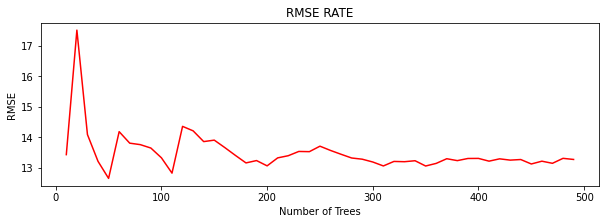

In [ ]:
plt.figure(figsize=(10,3))
plt.title('RMSE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
sns.lineplot(x=random_tree,y=rmse, color='red')

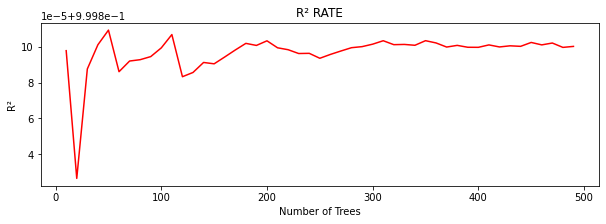

In [ ]:
plt.figure(figsize=(10,3))
plt.title('R² RATE')
plt.xlabel('Number of Trees')
plt.ylabel('R²')
sns.lineplot(x=random_tree,y=r_sq, color='red')

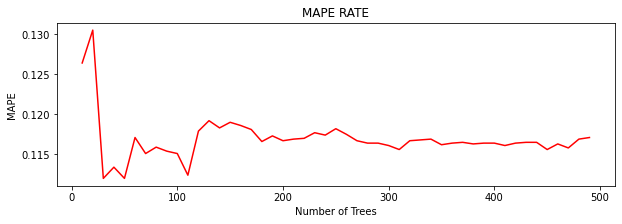

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAPE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('MAPE')
sns.lineplot(x=random_tree,y=mape, color='red')

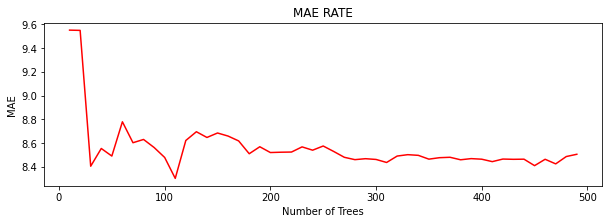

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
sns.lineplot(x=random_tree,y=mae, color='red')

A priori, a partir de los 150 árboles los errores **RMSE, MAPE, MAE** son menores y alcanzan cierta estabilidad. Se plantea contruir el modelo con 150 árboles 

# Errors modifying depth

In [ ]:
#Looking for the best nº estimators

random_depth = [i*2 for i in range(1,16)] 
rmse , r_sq , mae , mape = [],[],[],[]
for depth_size in random_depth:
    print('Depth Size:', depth_size)
    model_depth = RandomForestRegressor(n_estimators=150,  random_state=42, max_depth=int(depth_size)).fit(X_train,y_train)
    model_depth.fit(X_train, y_train)
    estimation = model_depth.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])

Depth Size: 2
RMSE:  963.9416276710798
R²:  0.47440004244871603
MAE:  832.6993790694627
MAPE : 10.6013
Model Accuracy(%) : 89.3987
Depth Size: 4
RMSE:  144.14033524777685
R²:  0.9882476448834786
MAE:  120.7914947776394
MAPE : 1.5958
Model Accuracy(%) : 98.4042
Depth Size: 6
RMSE:  28.056988908863595
R²:  0.9995547171474092
MAE:  21.256493324667442
MAPE : 0.2864
Model Accuracy(%) : 99.7136
Depth Size: 8
RMSE:  15.111774316108928
R²:  0.9998708231266796
MAE:  10.384084448558902
MAPE : 0.1415
Model Accuracy(%) : 99.8585
Depth Size: 10
RMSE:  13.93388870255043
R²:  0.9998901756795294
MAE:  8.666472849126436
MAPE : 0.1189
Model Accuracy(%) : 99.8811
Depth Size: 12
RMSE:  14.262995693295279
R²:  0.9998849264920835
MAE:  8.7303442470706
MAPE : 0.1201
Model Accuracy(%) : 99.8799
Depth Size: 14
RMSE:  13.918650314920747
R²:  0.9998904157604559
MAE:  8.528081730204072
MAPE : 0.117
Model Accuracy(%) : 99.883
Depth Size: 16
RMSE:  13.920873580689165
R²:  0.9998903807492528
MAE:  8.703890059844811


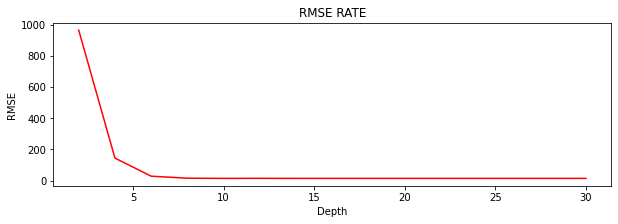

In [ ]:
plt.figure(figsize=(10,3))
plt.title('RMSE RATE')
plt.xlabel('Depth')
plt.ylabel('RMSE')
sns.lineplot(x=random_depth,y=rmse, color='red')

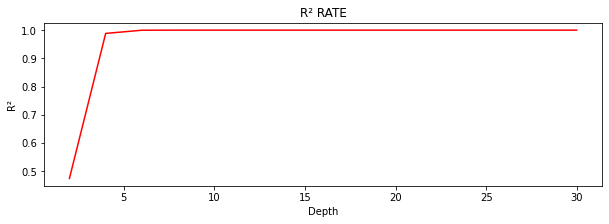

In [ ]:
plt.figure(figsize=(10,3))
plt.title('R² RATE')
plt.xlabel('Depth')
plt.ylabel('R²')
sns.lineplot(x=random_depth,y=r_sq, color='red')

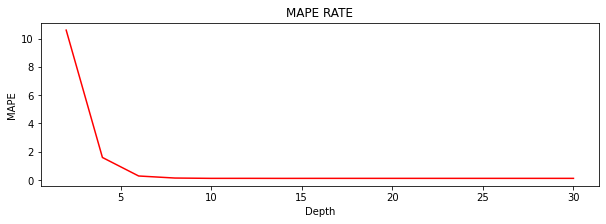

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAPE RATE')
plt.xlabel('Depth')
plt.ylabel('MAPE')
sns.lineplot(x=random_depth,y=mape, color='red')

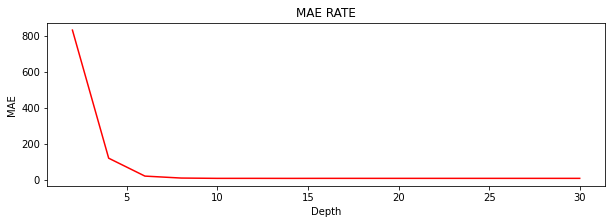

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAE RATE')
plt.xlabel('Depth')
plt.ylabel('MAE')
sns.lineplot(x=random_depth,y=mae, color='red')

A priori, a partir de una profundidad de 6 los errores RMSE, MAPE, MAE son menores y alcanzan cierta estabilidad. Se plantea contruir el modelo con 150 árboles y profundidad 6. 

# Modelo con 150 árboles y profundidad 6 (en base a los resultados)


In [ ]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train), 
                m.score(X_val, y_val)]
    print(f"RMSE training set: {res[0]} \nRMSE validation set: {res[1]} \nR² training set: {res[2]} \nR² validation set: {res[3]}")

In [ ]:
modified_final = RandomForestRegressor(n_estimators=150, max_depth=6, random_state=42) 
modified_final.fit(X_train, y_train)

print_score(modified_final)

RMSE training set: 37.01172574240263 
RMSE validation set: 28.05698890886359 
R² training set: 0.9999096143267824 
R² validation set: 0.9995547171474092


# Random Search with Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 45)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30], 'bootstrap': [True]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring='neg_mean_squared_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=False)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 34,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 240}

**Evaluate the Best Random Search Model**

In [ ]:
best_random = rf_random.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_random.n_estimators)
estimation = best_random.predict(X_val)
result_best = reg_acc(y_val,estimation)
rmse.append(result_best[0])
r_sq.append(result_best[1])
mae.append(result_best[2])
mape.append(result_best[3])

Model Performance

Tree Size: 240
RMSE:  13.805050168768748
R²:  0.999892197252711
MAE:  8.909204406639072
MAPE : 0.1227
Model Accuracy(%) : 99.8773


#Grid Search
We will perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,25,30],
    'max_features': ['auto'],
    'min_samples_leaf': [2,4,6],
    'min_samples_split': [6,8,9],
    'n_estimators': [200,250,300]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=False, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.7min finished


In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 250}

In [ ]:
best_grid = grid_search.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_grid.n_estimators)
estimation = best_grid.predict(X_val)
result_best_grid = reg_acc(y_val,estimation)
rmse.append(result_best_grid[0])
r_sq.append(result_best_grid[1])
mae.append(result_best_grid[2])
mape.append(result_best_grid[3])

Model Performance

Tree Size: 250
RMSE:  13.917410474482507
R²:  0.9998904352825959
MAE:  9.108015741729636
MAPE : 0.1256
Model Accuracy(%) : 99.8744


#Another Round of Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,22,24,26],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [140,160,180]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2,scoring='neg_mean_squared_error', return_train_score=False)

grid_search_final.fit(X_train, y_train);

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.9min finished


In [ ]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 180}

In [ ]:
best_grid_final = grid_search_final.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_grid_final.n_estimators)
estimation = best_grid_final.predict(X_val)
result_best_grid_final = reg_acc(y_val,estimation)
rmse.append(result_best_grid_final[0])
r_sq.append(result_best_grid_final[1])
mae.append(result_best_grid_final[2])
mape.append(result_best_grid_final[3])

Model Performance

Tree Size: 180
RMSE:  13.164900057423248
R²:  0.9999019632324864
MAE:  8.510413715169797
MAPE : 0.1166
Model Accuracy(%) : 99.8834


A very slight improvement in accuracy means we have reached the point of diminishing returns from tuning. We will stop here and use this as our final model.

#Final Model

In [ ]:
final_model = grid_search_final.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', final_model.n_estimators)
estimation = final_model.predict(X_val)
result_final_model = reg_acc(y_val,estimation)
rmse.append(result_final_model[0])
r_sq.append(result_final_model[1])
mae.append(result_final_model[2])
mape.append(result_final_model[3])


Final Model Parameters:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 180,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance

Tree Size: 180
RMSE:  13.164900057423248
R²:  0.9999019632324864
MAE:  8.510413715169797
MAPE : 0.1166
Model Accuracy(%) : 99.8834


#Comparison of All Improvement Techniques

In [ ]:
# Time used for evaluating model run times
import time

In [ ]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, X_train, y_train, X_val, y_val):
    n_trees = model.get_params()['n_estimators']
    max_depth = model.get_params()['max_depth']
    min_samples_leaf = model.get_params()['min_samples_leaf']
    min_samples_split = model.get_params()['min_samples_split']

    n_features = X_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_val))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    rmse , r_sq , mae , mape = [],[],[],[]
    estimation = model.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])
    
    # Return results in a dictionary
    results = {'time': run_time, 'RMSE': result[0],'R²': result[1],'MAE': result[2], 
               'MAPE': result[3], 'accuracy': 100-result[3], 'n_trees': n_trees, 'n_features': n_features, 
               'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
    
    return results

**Random Search Best Model**

In [ ]:
random_results = evaluate_model(best_random, X_train, y_train, X_val, y_val)
random_results['model'] = 'best_random'

RMSE:  13.805050168768748
R²:  0.999892197252711
MAE:  8.909204406639072
MAPE : 0.1227
Model Accuracy(%) : 99.8773


**First Grid Search Best Model**

In [ ]:
first_grid_results = evaluate_model(best_grid, X_train, y_train, X_val, y_val)
first_grid_results['model'] = 'first_grid'

RMSE:  13.917410474482507
R²:  0.9998904352825959
MAE:  9.108015741729636
MAPE : 0.1256
Model Accuracy(%) : 99.8744


**Second Grid Search Best Model**

In [ ]:
final_model_results = evaluate_model(best_grid_final, X_train, y_train, X_val, y_val)
final_model_results['model'] = 'second_grid'

RMSE:  13.164900057423248
R²:  0.9999019632324864
MAE:  8.510413715169797
MAPE : 0.1166
Model Accuracy(%) : 99.8834


**Primer modelo planteado de RF**

In [ ]:
default_model_results = evaluate_model(default_model, X_train, y_train, X_val, y_val)
default_model_results['model'] = 'default_model'

RMSE:  13.436516412572452
R²:  0.9998978761393938
MAE:  9.551603481538566
MAPE : 0.1264
Model Accuracy(%) : 99.8736


**Segundo modelo: modificado nº árboles y min_samples_leaf**

In [ ]:
modified_trees_leaf_model_results = evaluate_model(modified_trees_leaf_model, X_train, y_train, X_val, y_val)
modified_trees_leaf_model_results['model'] = 'modified_trees_leaf_model'

RMSE:  71.14605296649692
R²:  0.9971367750294851
MAE:  53.92236503139293
MAPE : 0.7333
Model Accuracy(%) : 99.2667


**Tercer modelo: cambio de profundidad**

In [ ]:
modified_depth_model_results = evaluate_model(modified_depth_model, X_train, y_train, X_val, y_val)
modified_depth_model_results['model'] = 'modified_depth_model'

RMSE:  17.519482965159344
R²:  0.9998263813318005
MAE:  9.549496128461453
MAPE : 0.1305
Model Accuracy(%) : 99.8695


**Cuarto modelo: cambio de profundidad y nº árboles**

In [ ]:
modified_depth_and_trees_model_results = evaluate_model(modified_depth_and_trees_model, X_train, y_train, X_val, y_val)
modified_depth_and_trees_model_results['model'] = 'modified_depth_and_trees_model'

RMSE:  14.189764955383012
R²:  0.9998861051062886
MAE:  8.779573196282252
MAPE : 0.1171
Model Accuracy(%) : 99.8829


**Quinto modelo: Modelo final tras modificaciones manuales**

In [ ]:
modified_final_results = evaluate_model(modified_final, X_train, y_train, X_val, y_val)
modified_final_results['model'] = 'modified_final'

RMSE:  28.056988908863595
R²:  0.9995547171474092
MAE:  21.256493324667442
MAPE : 0.2864
Model Accuracy(%) : 99.7136


**Comparison**

In [ ]:
comparison = {'model' : [default_model_results['model'], modified_trees_leaf_model_results['model'], modified_depth_model_results['model'], modified_depth_and_trees_model_results['model'], modified_final_results['model'], random_results['model'], first_grid_results['model'], final_model_results['model']],
           'n_features' : [default_model_results['n_features'], modified_trees_leaf_model_results['n_features'], modified_depth_model_results['n_features'], modified_depth_and_trees_model_results['n_features'], modified_final_results['n_features'], random_results['n_features'], first_grid_results['n_features'], final_model_results['n_features']],
           'n_trees' : [default_model_results['n_trees'], modified_trees_leaf_model_results['n_trees'], modified_depth_model_results['n_trees'], modified_depth_and_trees_model_results['n_trees'], modified_final_results['n_trees'], random_results['n_trees'], first_grid_results['n_trees'], final_model_results['n_trees']],
           'max_depth' : [default_model_results['max_depth'], modified_trees_leaf_model_results['max_depth'], modified_depth_model_results['max_depth'], modified_depth_and_trees_model_results['max_depth'], modified_final_results['max_depth'], random_results['max_depth'], first_grid_results['max_depth'], final_model_results['max_depth']],
           'min_samples_leaf' : [default_model_results['min_samples_leaf'], modified_trees_leaf_model_results['min_samples_leaf'], modified_depth_model_results['min_samples_leaf'], modified_depth_and_trees_model_results['min_samples_leaf'], modified_final_results['min_samples_leaf'], random_results['min_samples_leaf'], first_grid_results['min_samples_leaf'], final_model_results['min_samples_leaf']],
           'min_samples_split' : [default_model_results['min_samples_split'], modified_trees_leaf_model_results['min_samples_split'], modified_depth_model_results['min_samples_split'], modified_depth_and_trees_model_results['min_samples_split'], modified_final_results['min_samples_split'], random_results['min_samples_split'], first_grid_results['min_samples_split'], final_model_results['min_samples_split']],
           'RMSE' : [default_model_results['RMSE'], modified_trees_leaf_model_results['RMSE'], modified_depth_model_results['RMSE'], modified_depth_and_trees_model_results['RMSE'], modified_final_results['RMSE'], random_results['RMSE'], first_grid_results['RMSE'], final_model_results['RMSE']],
           'R²' : [default_model_results['R²'], modified_trees_leaf_model_results['R²'], modified_depth_model_results['R²'], modified_depth_and_trees_model_results['R²'], modified_final_results['R²'], random_results['R²'], first_grid_results['R²'], final_model_results['R²']],
           'MAE' : [default_model_results['MAE'], modified_trees_leaf_model_results['MAE'], modified_depth_model_results['MAE'], modified_depth_and_trees_model_results['MAE'], modified_final_results['MAE'], random_results['MAE'], first_grid_results['MAE'], final_model_results['MAE']],
           'MAPE' : [default_model_results['MAPE'], modified_trees_leaf_model_results['MAPE'], modified_depth_model_results['MAPE'], modified_depth_and_trees_model_results['MAPE'], modified_final_results['MAPE'], random_results['MAPE'], first_grid_results['MAPE'], final_model_results['MAPE']],
           'accuracy' : [default_model_results['accuracy'], modified_trees_leaf_model_results['accuracy'], modified_depth_model_results['accuracy'], modified_depth_and_trees_model_results['accuracy'], modified_final_results['accuracy'], random_results['accuracy'], first_grid_results['accuracy'], final_model_results['accuracy']],
           'time' : [default_model_results['time'], modified_trees_leaf_model_results['time'], modified_depth_model_results['time'], modified_depth_and_trees_model_results['time'], modified_final_results['time'], random_results['time'], first_grid_results['time'], final_model_results['time']]}


comparison = pd.DataFrame(comparison, columns = ['model', 'n_features', 'n_trees','max_depth','min_samples_leaf','min_samples_split','RMSE','R²','MAE','MAPE','accuracy','time'])
comparison



,model,n_features,n_trees,max_depth,min_samples_leaf,min_samples_split,RMSE,R²,MAE,MAPE,accuracy,time
0,default_model,4,10,NaN,1,2,13.436516,0.999898,9.551603,0.1264,99.8736,0.037610
1,modified_trees_leaf_model,4,40,NaN,25,2,71.146053,0.997137,53.922365,0.7333,99.2667,0.091861
2,modified_depth_model,4,20,20.0,1,2,17.519483,0.999826,9.549496,0.1305,99.8695,0.075599
3,modified_depth_and_trees_model,4,60,20.0,1,2,14.189765,0.999886,8.779573,0.1171,99.8829,0.209021
4,modified_final,4,150,6.0,1,2,28.056989,0.999555,21.256493,0.2864,99.7136,0.367994
5,best_random,4,240,34.0,1,4,13.805050,0.999892,8.909204,0.1227,99.8773,0.757826
6,first_grid,4,250,20.0,2,6,13.917410,0.999890,9.108016,0.1256,99.8744,0.727216
7,second_grid,4,180,20.0,1,2,13.164900,0.999902,8.510414,0.1166,99.8834,0.631875


# Plotting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

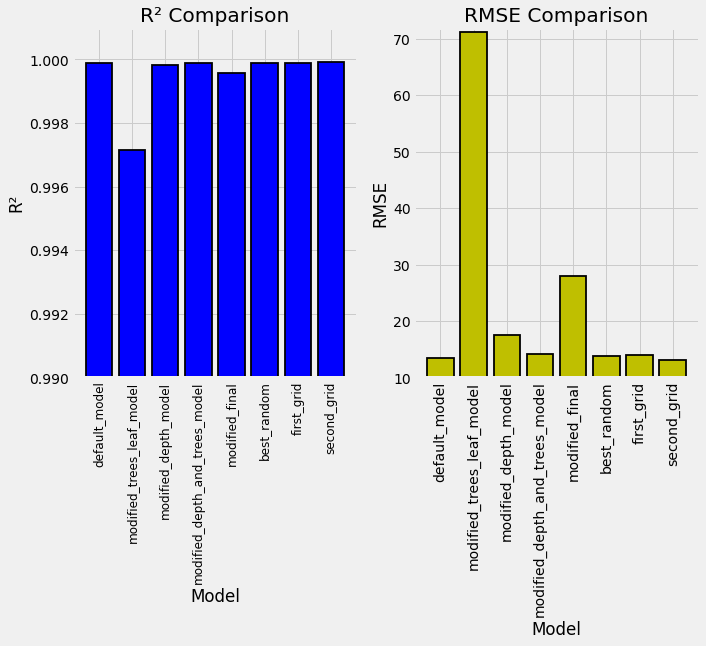

In [ ]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['R²'], color = 'b', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90, fontsize = 12)
plt.ylim(ymin = 0.99, ymax = 1.001)
plt.xlabel('Model'); plt.ylabel('R²'); plt.title('R² Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['RMSE'], color = 'y', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90)
plt.ylim(ymin = 10, ymax = 72)
plt.xlabel('Model'); plt.ylabel('RMSE'); plt.title('RMSE Comparison');

plt.show();

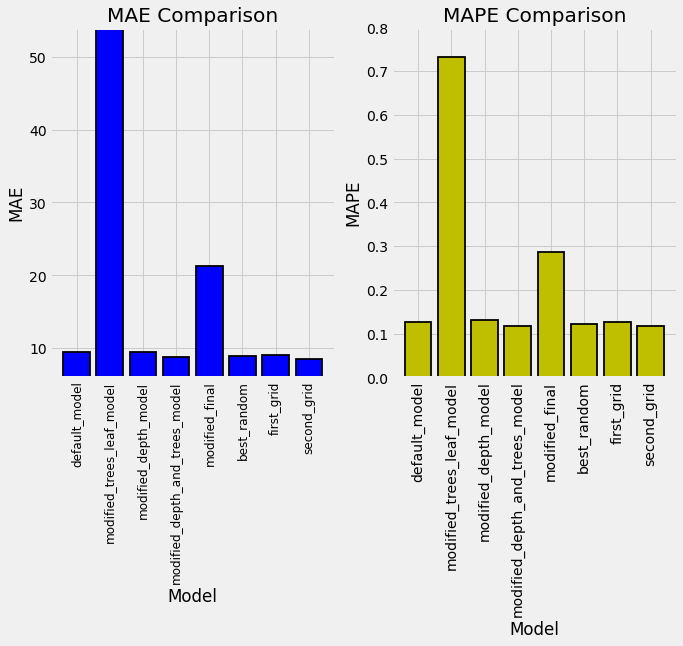

In [ ]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['MAE'], color = 'b', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90, fontsize = 12)
plt.ylim(ymin = 6, ymax = 54)
plt.xlabel('Model'); plt.ylabel('MAE'); plt.title('MAE Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['MAPE'], color = 'y', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90)
plt.ylim(ymin = 0, ymax = 0.8)
plt.xlabel('Model'); plt.ylabel('MAPE'); plt.title('MAPE Comparison');

plt.show();

# Gráfica valores reales vs predichos

In [ ]:
preds = np.stack([t.predict(X_val) for t in final_model.estimators_])

In [ ]:
#Comparing our model’s results against the validation set, here is the row of predictions, the mean of the predictions 
#and the actual value from validation set.

print("0th Row for prediction from all trees:")
print(preds[:,0])
print("\nMean of the predictions:")
print(np.mean(preds[:,0]) )
print("\nActual value:")
print(y_val[0])

0th Row for prediction from all trees:
[7397.796875 7397.796875 7434.390137 7406.52002  ... 7355.879883 7424.29248  7379.950195 7355.879883]

Mean of the predictions:
7405.9366672611095

Actual value:
7400.899414


In [ ]:
rf_test_pred_final = final_model.predict(X_val)
rf_prediction_values = pd.DataFrame({'Actual close price for next candlestick':y_val,'Predicted close price for next candlestick':rf_test_pred_final})
rf_prediction_values.head(10)

,Actual close price for next candlestick,Predicted close price for next candlestick
timestamp,,
12/9/2019,7400.899414,7405.936667
12/10/2019,7278.119629,7271.598237
12/11/2019,7217.427246,7218.455057
12/12/2019,7243.134277,7255.284193
12/13/2019,7269.684570,7268.411714
12/14/2019,7124.673828,7140.969911
12/15/2019,7152.301758,7142.407289
12/16/2019,6932.480469,6947.437283
12/17/2019,6640.515137,6643.025903


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text major ticklabel objects>)

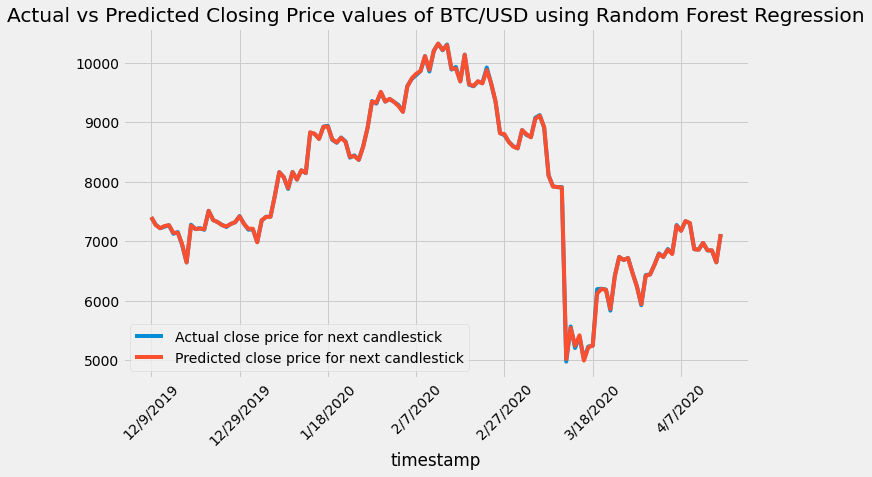

In [ ]:
rf_prediction_values[['Actual close price for next candlestick','Predicted close price for next candlestick']].plot(figsize = (10,6))
plt.title('Actual vs Predicted Closing Price values of BTC/USD using Random Forest Regression')
plt.xticks(rotation=45)

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 10 Text major ticklabel objects>)

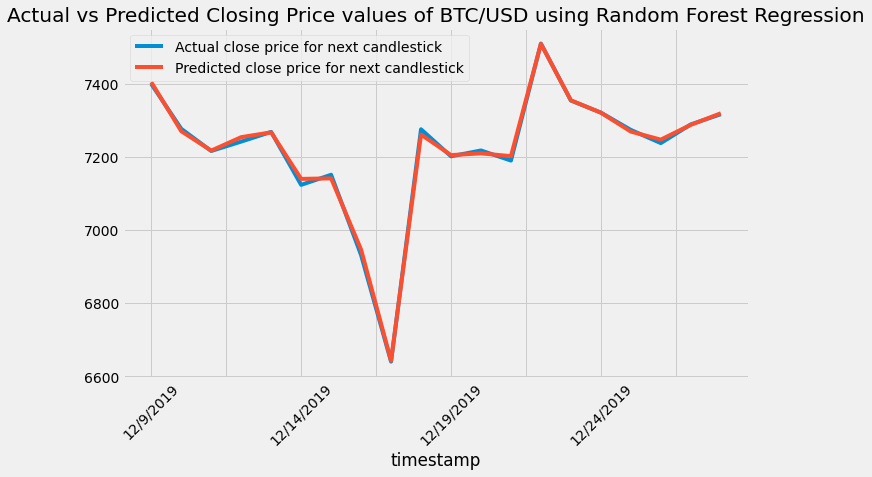

In [ ]:
rf_prediction_values.head(20)[['Actual close price for next candlestick','Predicted close price for next candlestick']].plot(figsize = (10,6))
plt.title('Actual vs Predicted Closing Price values of BTC/USD using Random Forest Regression')
plt.xticks(rotation=45)

# Importancia de las variables

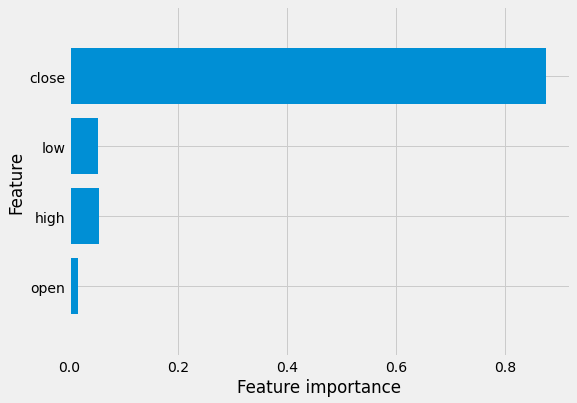

In [ ]:
def plot_feature_importances_features(final_model):
    plt.figure(figsize=(8,6))
    n_features = 4
    plt.barh(range(n_features), final_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_features(final_model)
plt.savefig('feature_importance')

In [ ]:
for feature in zip(features, final_model.feature_importances_):
    print(feature)

('open', 0.017307638428999905)
('high', 0.05472737351549288)
('low', 0.05304416494761441)
('close', 0.8749208231078928)


# Representación de árboles de RF



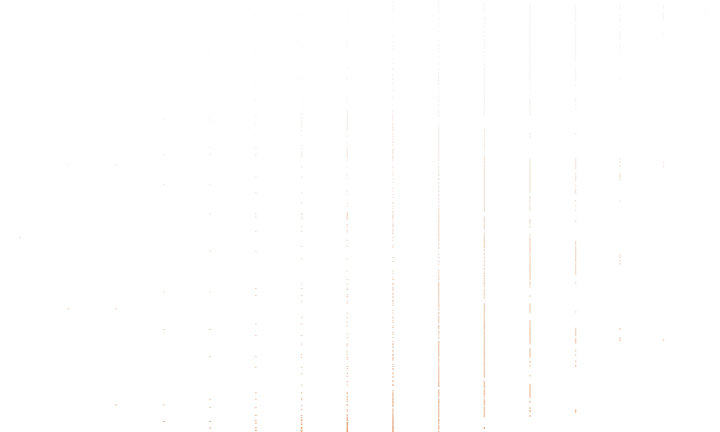

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    

draw_tree(final_model.estimators_[0], X_train, precision=3)

# Crypto Direction

In [ ]:
df_col = pd.concat([X_val['close'],rf_prediction_values], axis=1)
df_col

,close,Actual close price for next candlestick,Predicted close price for next candlestick
timestamp,,,
12/9/2019,7400.899414,7400.899414,7405.936667
12/10/2019,7278.119629,7278.119629,7271.598237
12/11/2019,7217.427246,7217.427246,7218.455057
12/12/2019,7243.134277,7243.134277,7255.284193
12/13/2019,7269.684570,7269.684570,7268.411714
...,...,...,...
4/12/2020,6971.091797,6971.091797,6970.770245
4/13/2020,6845.037598,6845.037598,6845.672309
4/14/2020,6842.427734,6842.427734,6845.016084


In [ ]:
df_col['Evolution of Close price'] = np.where(df_col['Actual close price for next candlestick']  > df_col['close'], 'UP', 'DOWN')

df_col['Direction of predictions'] = np.where((((df_col['Predicted close price for next candlestick']  > df_col['Actual close price for next candlestick']) | (df_col['Predicted close price for next candlestick']  > df_col['close'])) & (df_col['Actual close price for next candlestick'] > df_col['close']) | (((df_col['Predicted close price for next candlestick']  < df_col['Actual close price for next candlestick']) | (df_col['Predicted close price for next candlestick']  < df_col['close'])) & (df_col['Actual close price for next candlestick'] < df_col['close']))), 'OK', 'WRONG')

In [ ]:
df_col

,close,Actual close price for next candlestick,Predicted close price for next candlestick,Evolution of Close price,Direction of predictions
timestamp,,,,,
12/9/2019,7400.899414,7400.899414,7405.936667,DOWN,WRONG
12/10/2019,7278.119629,7278.119629,7271.598237,DOWN,WRONG
12/11/2019,7217.427246,7217.427246,7218.455057,DOWN,WRONG
12/12/2019,7243.134277,7243.134277,7255.284193,DOWN,WRONG
12/13/2019,7269.684570,7269.684570,7268.411714,DOWN,WRONG
...,...,...,...,...,...
4/12/2020,6971.091797,6971.091797,6970.770245,DOWN,WRONG
4/13/2020,6845.037598,6845.037598,6845.672309,DOWN,WRONG
4/14/2020,6842.427734,6842.427734,6845.016084,DOWN,WRONG


In [ ]:
df_col['Direction of predictions'].str.split(expand=True).stack().value_counts()

WRONG    130
dtype: int64